In [1]:
# import basic library
import pickle
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split

In [2]:
# read the data set
with open ('time_series_1.pickle','rb' ) as handle:
    time_series_1 = pickle.load(handle)
with open ('time_series_2.pickle','rb' ) as handle:
    time_series_2 = pickle.load(handle)
with open ('y.pickle','rb' ) as handle:
    y = pickle.load(handle)

### Task 1
Create a recurrent neural network in TensorFlow to predict the operating mode of a
wind turbine based on the two time series from the sensors. Before any
implementation, carefully consider what type of approach (sequence-to-vector,
sequence-to-sequence, or encoder-decoder) is most sensible here and how you need to
manipulate the data, given that you have two different time series for each observation.     
Then, make sure that you try out the different layers and elements discussed in class,
such as SimpleRNN, LSTM and Conv1D - while a certain amount of trial and error will be
necessary, it is recommended that you tune your network systematically. Make sure to
record your final validation set accuracy.
Another tool for analyzing time-series data is convolutional neural networks with 2D
convolutional layers. For this to work, time series need to be converted into “images” (matrices
of numbers).     

Another tool for analyzing time-series data is convolutional neural networks with 2D
convolutional layers. For this to work, time series need to be converted into “images” (matrices
of numbers). The paper
“Convolutional neural network fault classification based on time series analysis for
benchmark wind turbine machine” by Rahimilarki, Gao, Jin, and Zhang (published 2022
in “Renewable Energy” and available through the City-library)
describes how two-dimensional CNNs can be applied to the problem at hand. Consider sections
4 and 5 that depict the process of converting one or multiple time series into “images” used
within a CNN.

In [4]:
# import library for task 1
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, SimpleRNN, BatchNormalization, LSTM, Conv1D, Embedding, GRU, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [5]:
# one-hot encoding for y
y_cate = to_categorical(y)

In [6]:
# check the devide is running on gpu or not
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13156573232782402933
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4162256896
locality {
  bus_id: 1
  links {
  }
}
incarnation: 7041657354655398803
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [7]:
# stack two time series as a new format [timeseries_1, timeseries_2]
data = np.dstack((time_series_1,time_series_2))

In [11]:
data_sample = data[:1000,]
y_sample = y_cate[:1000,]

In [12]:
data_sample.shape, y_sample.shape

((1000, 5000, 2), (1000, 4))

In [14]:
#split the dataset into 70% train, 15% valid and 15% test
X_train_sample, X_other_sample, y_train_sample, y_other_sample = train_test_split(data_sample, y_sample, test_size=0.3, random_state = 657)
X_test_sample, X_valid_sample, y_test_sample, y_valid_sample = train_test_split(X_other_sample, y_other_sample, train_size = 0.5, random_state=391)

In [174]:
#split the dataset into 70% train, 15% valid and 15% test
X_train, X_other, y_train, y_other = train_test_split(data, y_cate, test_size=0.3, random_state = 657)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=391)

In [112]:
#def the training process
def train_plot(model, learning_rate = 0.001, epochs = 30):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="mse",metrics = "acc",
                  optimizer=Adam(learning_rate = learning_rate))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['acc'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_acc'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

##### model.1. baseline

In [113]:
# baseline
model = Sequential([
    Flatten(input_shape=[5000, 2]),
    Dense(4)
])
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 10000)             0         
                                                                 
 dense_27 (Dense)            (None, 4)                 40004     
                                                                 
Total params: 40,004
Trainable params: 40,004
Non-trainable params: 0
_________________________________________________________________


Epoch 1/30
88/88 [==============================] - 1s 8ms/step - loss: 31338.5352 - acc: 0.2382 - val_loss: 174.5140 - val_acc: 0.2567
Epoch 2/30
88/88 [==============================] - 0s 5ms/step - loss: 116.1459 - acc: 0.2129 - val_loss: 99.3041 - val_acc: 0.2267
Epoch 3/30
88/88 [==============================] - 0s 5ms/step - loss: 71.3764 - acc: 0.2479 - val_loss: 58.5780 - val_acc: 0.2867
Epoch 4/30
88/88 [==============================] - 0s 5ms/step - loss: 47.3519 - acc: 0.2461 - val_loss: 38.3473 - val_acc: 0.2933
Epoch 5/30
88/88 [==============================] - 0s 5ms/step - loss: 38.2851 - acc: 0.2679 - val_loss: 39.1460 - val_acc: 0.2850
Epoch 6/30
88/88 [==============================] - 0s 5ms/step - loss: 32.8094 - acc: 0.2807 - val_loss: 31.8651 - val_acc: 0.2817
Epoch 7/30
88/88 [==============================] - 0s 5ms/step - loss: 32.8260 - acc: 0.2761 - val_loss: 33.5232 - val_acc: 0.2567
Epoch 8/30
88/88 [==============================] - 0s 5ms/step - loss:

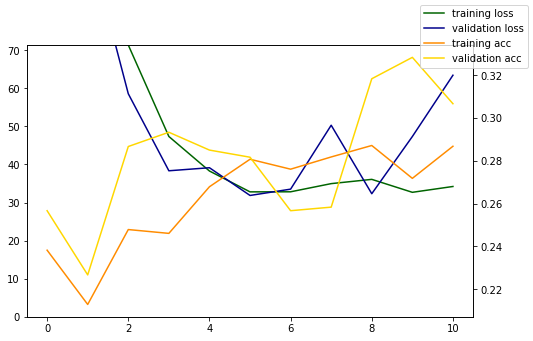

In [114]:
train_plot(model)

##### model.2. simple RNN

In [18]:
def train_plot(model, learning_rate = 0.001, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="mse",metrics = "acc",
                  optimizer=Adam(learning_rate = learning_rate))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train_sample, y_train_sample, epochs=epochs,batch_size=50,
                        validation_data=(X_valid_sample, y_valid_sample),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['acc'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_acc'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

In [20]:
# simple RNN
model = Sequential([
    ###the reccurrent process feature by feature and adjust the input hence the input_shape's x is none
    SimpleRNN(4, input_shape=[None,2])
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 4)                 28        
                                                                 
Total params: 28
Trainable params: 28
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
14/14 [==============================] - 46s 3s/step - loss: 1.1461 - acc: 0.2314 - val_loss: 1.0936 - val_acc: 0.2867
Epoch 2/20
14/14 [==============================] - 44s 3s/step - loss: 1.1422 - acc: 0.2314 - val_loss: 1.0929 - val_acc: 0.2867
Epoch 3/20
14/14 [==============================] - 46s 3s/step - loss: 1.1416 - acc: 0.2314 - val_loss: 1.0925 - val_acc: 0.2867
Epoch 4/20
14/14 [==============================] - 44s 3s/step - loss: 1.1409 - acc: 0.2314 - val_loss: 1.0925 - val_acc: 0.2867
Epoch 5/20
14/14 [==============================] - 44s 3s/step - loss: 1.1401 - acc: 0.2314 - val_loss: 1.0917 - val_acc: 0.2867
Epoch 6/20
14/14 [==============================] - 46s 3s/step - loss: 1.1396 - acc: 0.2314 - val_loss: 1.0913 - val_acc: 0.2867
Epoch 7/20
14/14 [==============================] - 45s 3s/step - loss: 1.1389 - acc: 0.2314 - val_loss: 1.0907 - val_acc: 0.2867
Epoch 8/20
14/14 [==============================] - 45s 3s/step - loss: 1.1383 - acc: 0.23

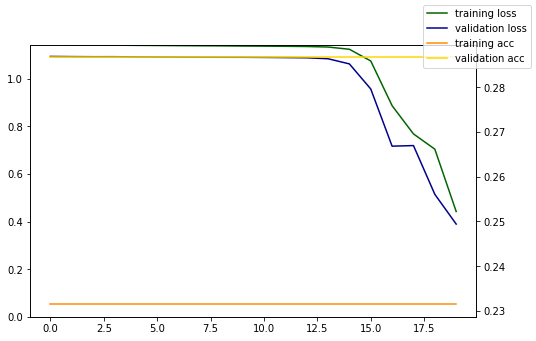

In [21]:
train_plot(model)

##### model.3. deeper RNN - sequence to vector

In [22]:
# sequence to vector RNN
model = Sequential([
    ###return_sequences=True -> the output is a sequence output
    SimpleRNN(10, return_sequences=True, input_shape=[None, 2]),
    SimpleRNN(10),
    Dense(4, activation="softmax")
])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (None, None, 10)          130       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 10)                210       
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
Total params: 384
Trainable params: 384
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
14/14 [==============================] - 138s 10s/step - loss: 0.2163 - acc: 0.2429 - val_loss: 0.2070 - val_acc: 0.2133
Epoch 2/20
14/14 [==============================] - 136s 10s/step - loss: 0.2053 - acc: 0.2429 - val_loss: 0.1998 - val_acc: 0.2133
Epoch 3/20
14/14 [==============================] - 139s 10s/step - loss: 0.1999 - acc: 0.2771 - val_loss: 0.1950 - val_acc: 0.2733
Epoch 4/20
14/14 [==============================] - 136s 10s/step - loss: 0.1947 - acc: 0.2729 - val_loss: 0.1898 - val_acc: 0.2733
Epoch 5/20
14/14 [==============================] - 135s 10s/step - loss: 0.1891 - acc: 0.2729 - val_loss: 0.1874 - val_acc: 0.2733
Epoch 6/20
14/14 [==============================] - 137s 10s/step - loss: 0.1872 - acc: 0.2829 - val_loss: 0.1877 - val_acc: 0.2267
Epoch 7/20
14/14 [==============================] - 136s 10s/step - loss: 0.1867 - acc: 0.2514 - val_loss: 0.1867 - val_acc: 0.3067
Epoch 8/20
14/14 [==============================] - 136s 10s/step - loss: 0.

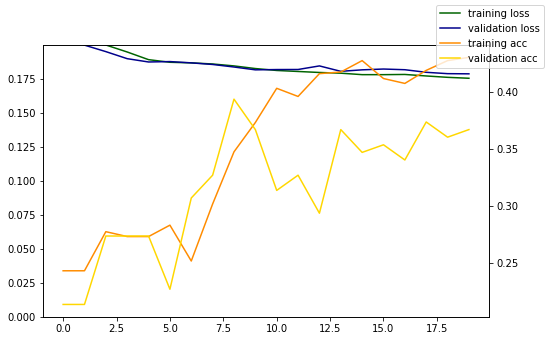

In [23]:
train_plot(model)

Regarding to the computing speed and the low accuracy based on sample data, RNN and simple RNN will not considered for processing the whole dataset.

##### model.4. LSTM

In [170]:
def train_plot(model, learning_rate = 0.001, epochs = 40):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",metrics = "acc",
                  optimizer=Adam(learning_rate = learning_rate))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,batch_size=30,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['acc'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_acc'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

In [175]:
# LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=[None, 2]), 
    #activity_regularizer=tf.keras.regularizers.L2(0.001)),
    LSTM(50,dropout=0.2),
    Dense(4,activation='softmax')
])
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 50)          10600     
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dense_35 (Dense)            (None, 4)                 204       
                                                                 
Total params: 31,004
Trainable params: 31,004
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
94/94 [==============================] - 36s 339ms/step - loss: 1.3546 - acc: 0.3329 - val_loss: 1.3060 - val_acc: 0.3667
Epoch 2/40
94/94 [==============================] - 31s 330ms/step - loss: 1.2733 - acc: 0.4111 - val_loss: 1.2530 - val_acc: 0.4383
Epoch 3/40
94/94 [==============================] - 31s 330ms/step - loss: 1.2433 - acc: 0.4332 - val_loss: 1.1735 - val_acc: 0.5117
Epoch 4/40
94/94 [==============================] - 31s 331ms/step - loss: 1.1937 - acc: 0.4729 - val_loss: 1.2091 - val_acc: 0.4867
Epoch 5/40
94/94 [==============================] - 31s 332ms/step - loss: 1.1626 - acc: 0.4829 - val_loss: 1.1058 - val_acc: 0.5100
Epoch 6/40
94/94 [==============================] - 31s 331ms/step - loss: 1.1351 - acc: 0.5004 - val_loss: 1.0742 - val_acc: 0.5350
Epoch 7/40
94/94 [==============================] - 31s 332ms/step - loss: 1.0702 - acc: 0.5257 - val_loss: 1.0229 - val_acc: 0.5383
Epoch 8/40
94/94 [==============================] - 32s 336ms/step - 

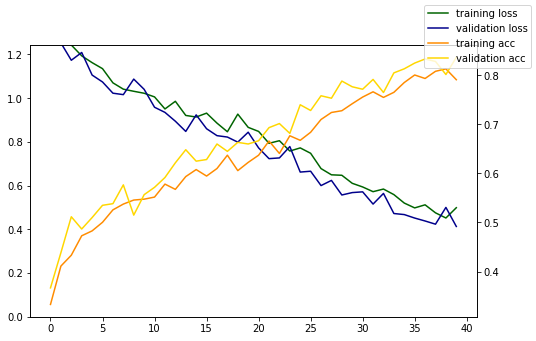

In [176]:
train_plot(model)

In [177]:
# record the accuracy
accr_lstm = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_lstm[0],accr_lstm[1]))

19/19 [==============================] - 4s 144ms/step - loss: 0.4544 - acc: 0.8200
Test set
  Loss: 0.454
  Accuracy: 0.820


##### model.5. GRU

In [179]:
def train_plot(model, learning_rate = 0.005, epochs = 40):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",metrics = "acc",
                  optimizer=Adam(learning_rate = learning_rate))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['acc'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_acc'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

In [180]:
model = Sequential([
    GRU(128, return_sequences=True, input_shape=[None, 2]),
    GRU(128),
    Dense(4,activation="softmax")
])
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_2 (GRU)                 (None, None, 128)         50688     
                                                                 
 gru_3 (GRU)                 (None, 128)               99072     
                                                                 
 dense_36 (Dense)            (None, 4)                 516       
                                                                 
Total params: 150,276
Trainable params: 150,276
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
88/88 [==============================] - 40s 406ms/step - loss: 1.4787 - acc: 0.3043 - val_loss: 1.3150 - val_acc: 0.3233
Epoch 2/40
88/88 [==============================] - 33s 372ms/step - loss: 1.2145 - acc: 0.4368 - val_loss: 1.1770 - val_acc: 0.4250
Epoch 3/40
88/88 [==============================] - 33s 372ms/step - loss: 1.1252 - acc: 0.4939 - val_loss: 1.0288 - val_acc: 0.5550
Epoch 4/40
88/88 [==============================] - 33s 375ms/step - loss: 1.0827 - acc: 0.5179 - val_loss: 1.2571 - val_acc: 0.4800
Epoch 5/40
88/88 [==============================] - 33s 376ms/step - loss: 1.0394 - acc: 0.5318 - val_loss: 0.9345 - val_acc: 0.6017
Epoch 6/40
88/88 [==============================] - 33s 378ms/step - loss: 0.8689 - acc: 0.6068 - val_loss: 0.8461 - val_acc: 0.6367
Epoch 7/40
88/88 [==============================] - 34s 385ms/step - loss: 0.8584 - acc: 0.6286 - val_loss: 0.8181 - val_acc: 0.6750
Epoch 8/40
88/88 [==============================] - 35s 393ms/step - 

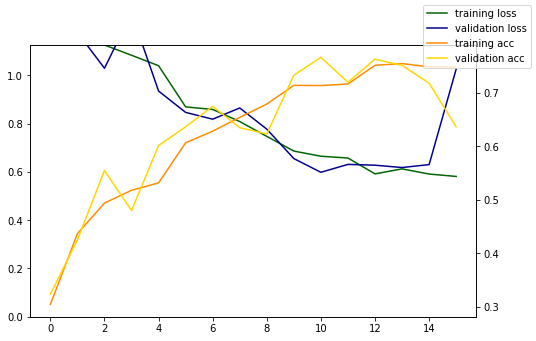

In [182]:
train_plot(model)

In [183]:
accr_gru = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_gru[0],accr_gru[1]))

19/19 [==============================] - 3s 142ms/step - loss: 0.6868 - acc: 0.7233
Test set
  Loss: 0.687
  Accuracy: 0.723


##### model.6. Conv1D

In [184]:
def train_plot(model, learning_rate = 0.001, epochs = 40):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",metrics = "acc",
                  optimizer=Adam(learning_rate = learning_rate))
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['acc'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_acc'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

In [185]:
# Conv 1D
model = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    GRU(128),
    Dense(4, activation="softmax")
])
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 20)          180       
                                                                 
 conv1d_7 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_8 (Conv1D)           (None, None, 20)          1620      
                                                                 
 gru_4 (GRU)                 (None, 128)               57600     
                                                                 
 dense_37 (Dense)            (None, 4)                 516       
                                                                 
Total params: 61,536
Trainable params: 61,536
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
88/88 [==============================] - 6s 38ms/step - loss: 1.1747 - acc: 0.4800 - val_loss: 0.9793 - val_acc: 0.5700
Epoch 2/40
88/88 [==============================] - 3s 30ms/step - loss: 0.8465 - acc: 0.6482 - val_loss: 0.6585 - val_acc: 0.7933
Epoch 3/40
88/88 [==============================] - 3s 31ms/step - loss: 0.5693 - acc: 0.7982 - val_loss: 0.4057 - val_acc: 0.8700
Epoch 4/40
88/88 [==============================] - 3s 30ms/step - loss: 0.3867 - acc: 0.8643 - val_loss: 0.3643 - val_acc: 0.8733
Epoch 5/40
88/88 [==============================] - 3s 31ms/step - loss: 0.3323 - acc: 0.8739 - val_loss: 0.2843 - val_acc: 0.9050
Epoch 6/40
88/88 [==============================] - 3s 31ms/step - loss: 0.2763 - acc: 0.8839 - val_loss: 0.2514 - val_acc: 0.9100
Epoch 7/40
88/88 [==============================] - 3s 30ms/step - loss: 0.2527 - acc: 0.8907 - val_loss: 0.2596 - val_acc: 0.9067
Epoch 8/40
88/88 [==============================] - 3s 30ms/step - loss: 0.2460 - a

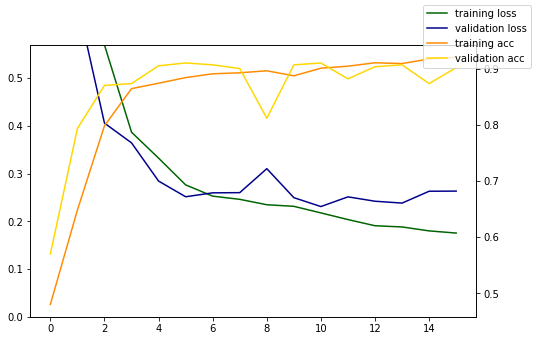

In [186]:
train_plot(model)

In [187]:
accr_con1d = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_con1d[0],accr_con1d[1]))

19/19 [==============================] - 1s 25ms/step - loss: 0.2765 - acc: 0.8900
Test set
  Loss: 0.276
  Accuracy: 0.890


In [194]:
df_accr = {'LSTM': accr_lstm, 'GRU': accr_gru, 'Conv1D': accr_con1d}

In [195]:
#build a table to recourd model difference
df_accr = pd.DataFrame(df_accr, index=['Loss', 'Accuracy'])
df_accr

,LSTM,GRU,Conv1D
Loss,0.454418,0.686813,0.276459
Accuracy,0.820000,0.723333,0.890000


Compared the three models, Conv1D has the best performance. With a long epochs training, the accuracy of LSTM is increasing slowly. GRU got the worst performance with accuracy 0.72

### Task 2
In your own words, explain why the approach outlined here can help analyze time-series
data and why it might outperform RNNs.

Recurrent neural networks use time-series information to identify patterns between the input and output. CNNs have numerous layers and each one is responsible for detecting a specific set of features in the image.    

For the time-series data, the CNN approach convert it into 2-d image matrix under grayscale. The patterns of how the signal changing vary from the time could be represented as pixels. The combination of two time series is considered as one pixel in the graph. Hence CNN can be applied to detect the patterns and see if there is any difference. The approach increse the computing speed for RNN has less feature compatibility and the output/input lengths can be taken as arbitrary which can affect the total computational time. However, CNN takes fixed input and gives a fixed output which allows it to compute the results at a faster pace.    

RNN should work well with a time-seires data, however, considering the data has 2 dimensions (angle and power), it may be harder for RNN to learn the patterns. Hence in the Conv1d model, the output from conv1d layer is vector, help GRU layer to learn the result better.



### Task 3
Convert the data for use with a CNN. In particular, following the approach outlined in
Scenario 2 (section 5.3 of the paper) and summarized in Figure 18, convert the two time
series corresponding to one wind turbine run into a single (100,100,1) array (i.e., a grayscale
image).

- get the signal pattern
- catch the change point in the signal plot

In [9]:
# import libraries for task 3
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D

In [65]:
num_classes = 4 # number of classes in the data
img_rows, img_cols, img_channels = 100, 100, 1 # input image dimensions

# Load and convert data
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_valid = X_valid.astype('float32')

# Depending on the implementation, the underlying libraries might want the image 
# dimensions in different orders, check for it and reshape
if K.image_data_format() == 'channels_first':
    X_train = X_train.reshape(X_train.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    X_valid = X_valid.reshape(X_valid.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    X_valid = X_valid.reshape(X_valid.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

print('x_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)

x_train shape: (2800, 100, 100, 1)
y_train shape: (2800, 4)


#### plot the signal for different categories

[0. 0. 0. 1.]


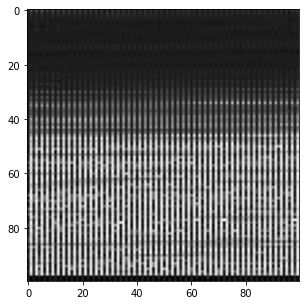

In [32]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[0].astype(int),cmap="gray")
print(y_train[0])

[1. 0. 0. 0.]


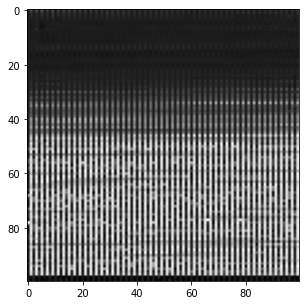

In [33]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[1].astype(int),cmap="gray")
print(y_train[1])

[0. 1. 0. 0.]


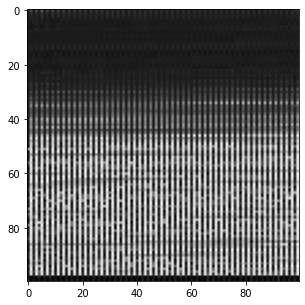

In [40]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[8].astype(int),cmap="gray")
print(y_train[8])

[0. 0. 1. 0.]


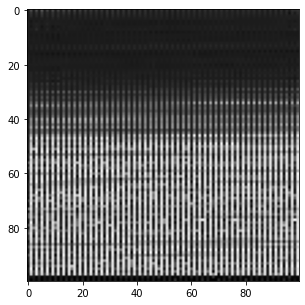

In [39]:
plt.figure(figsize=(5, 5))
plt.imshow(X_train[4].astype(int),cmap="gray")
print(y_train[4])

### Task 4
In TensorFlow, replicate the CNN with two convolutional layers displayed in Figure 12
and train it on your data. Make sure to record your final validation set accuracy.

In [115]:
# rebuild the model
model_cnn = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_cnn.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 conv2d_43 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 dropout_10 (Dropout)        (None, 25, 25, 32)        0         
                                                                 
 conv2d_44 (Conv2D)          (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 4, 4, 16)         0         
 g2D)                                                            
                                                                 
 flatten_10 (Flatten)        (None, 256)               0         
                                                     

In [116]:
def train_plot(model, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['accuracy'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_accuracy'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

Epoch 1/20
88/88 [==============================] - 2s 14ms/step - loss: 7.1261 - accuracy: 0.3436 - val_loss: 0.8097 - val_accuracy: 0.6617
Epoch 2/20
88/88 [==============================] - 1s 7ms/step - loss: 1.4185 - accuracy: 0.5996 - val_loss: 0.4013 - val_accuracy: 0.8233
Epoch 3/20
88/88 [==============================] - 1s 7ms/step - loss: 0.9303 - accuracy: 0.7207 - val_loss: 0.2987 - val_accuracy: 0.9150
Epoch 4/20
88/88 [==============================] - 1s 8ms/step - loss: 0.7188 - accuracy: 0.7914 - val_loss: 0.2560 - val_accuracy: 0.8817
Epoch 5/20
88/88 [==============================] - 1s 7ms/step - loss: 0.6282 - accuracy: 0.8082 - val_loss: 0.2533 - val_accuracy: 0.8933
Epoch 6/20
88/88 [==============================] - 1s 7ms/step - loss: 0.5392 - accuracy: 0.8271 - val_loss: 0.2461 - val_accuracy: 0.9033
Epoch 7/20
88/88 [==============================] - 1s 7ms/step - loss: 0.4946 - accuracy: 0.8361 - val_loss: 0.4213 - val_accuracy: 0.9067
Epoch 8/20
88/88 [=

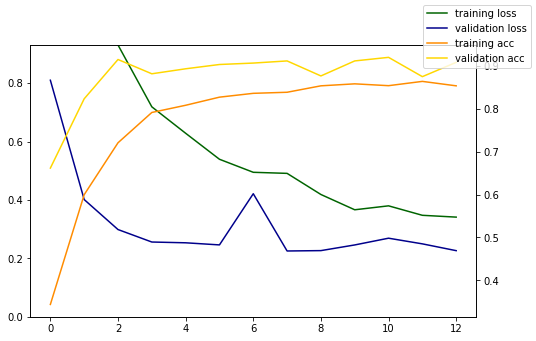

In [117]:
train_plot(model_cnn)

In [118]:
accr_cnn = model_cnn.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_cnn[0],accr_cnn[1]))

19/19 [==============================] - 0s 8ms/step - loss: 0.2873 - accuracy: 0.8783
Test set
  Loss: 0.287
  Accuracy: 0.878


### Task 5
Can you do better by adjusting the CNN? Be creative in your design choices (you might
also consider pre-trained CNN architectures) and record your final validation set
accuracy.

#### method1: stack more layers and add neurons
add one more conv2D layer, increasing the neuron numbers from 128 to 16

In [82]:
model_cnn_1 = Sequential([
    Conv2D(128, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(64, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_cnn_1.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_cnn_1.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 50, 50, 128)       1280      
                                                                 
 conv2d_31 (Conv2D)          (None, 25, 25, 64)        73792     
                                                                 
 dropout_8 (Dropout)         (None, 25, 25, 64)        0         
                                                                 
 conv2d_32 (Conv2D)          (None, 13, 13, 32)        18464     
                                                                 
 conv2d_33 (Conv2D)          (None, 7, 7, 16)          4624      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 2, 2, 16)         0         
 2D)                                                             
                                                     

In [83]:
def train_plot(model, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(X_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(X_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['accuracy'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_accuracy'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

Epoch 1/20
88/88 [==============================] - 2s 21ms/step - loss: 5.1401 - accuracy: 0.2975 - val_loss: 1.2132 - val_accuracy: 0.4800
Epoch 2/20
88/88 [==============================] - 1s 16ms/step - loss: 0.9839 - accuracy: 0.5757 - val_loss: 0.6330 - val_accuracy: 0.7517
Epoch 3/20
88/88 [==============================] - 1s 16ms/step - loss: 0.5412 - accuracy: 0.8011 - val_loss: 0.2852 - val_accuracy: 0.9183
Epoch 4/20
88/88 [==============================] - 1s 17ms/step - loss: 0.3778 - accuracy: 0.8557 - val_loss: 0.2216 - val_accuracy: 0.9183
Epoch 5/20
88/88 [==============================] - 1s 17ms/step - loss: 0.3402 - accuracy: 0.8614 - val_loss: 0.2129 - val_accuracy: 0.9200
Epoch 6/20
88/88 [==============================] - 1s 17ms/step - loss: 0.3197 - accuracy: 0.8711 - val_loss: 0.2086 - val_accuracy: 0.9167
Epoch 7/20
88/88 [==============================] - 1s 17ms/step - loss: 0.3020 - accuracy: 0.8754 - val_loss: 0.2187 - val_accuracy: 0.9200
Epoch 8/20
88

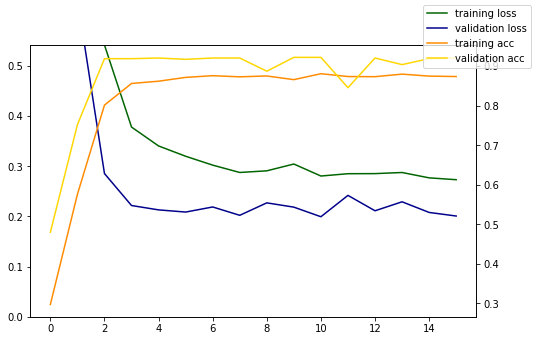

In [84]:
train_plot(model_cnn_1)

In [86]:
accr_cnn_1 = model_cnn_1.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_cnn_1[0],accr_cnn_1[1]))

19/19 [==============================] - 0s 7ms/step - loss: 0.2535 - accuracy: 0.8517
Test set
  Loss: 0.253
  Accuracy: 0.852


#### method2: scale the dataset
the data set is scaled to show a more clear pattern

In [49]:
# import libraries
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input

In [88]:
# preprocess the data
x_preprocess_train = preprocess_input(X_train.copy())
x_preprocess_test = preprocess_input(X_test.copy())
x_preprocess_valid = preprocess_input(X_valid.copy())
x_preprocess_train.shape, x_preprocess_test.shape, x_preprocess_valid.shape

((2800, 100, 100, 1), (600, 100, 100, 1), (600, 100, 100, 1))

[0. 0. 1. 0.]


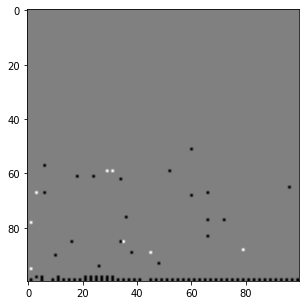

In [52]:
# plot the figure
plt.figure(figsize=(5, 5))
plt.imshow(x_preprocess_train[4].astype(int),cmap="gray")
print(y_train[4])

In [87]:
# build the model
model_cnn_2 = Sequential([
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same',input_shape=input_shape),
    Conv2D(32, kernel_size=(3, 3),strides=(2,2),padding='same'),
    Dropout(0.2),
    Conv2D(16, kernel_size=(3, 3),strides=(2,2),padding='same',activation='relu'),
    MaxPooling2D(pool_size=(3, 3)),
    Flatten(),
    Dense(num_classes, activation='softmax')])

model_cnn_2.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_cnn_2.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 50, 50, 32)        320       
                                                                 
 conv2d_35 (Conv2D)          (None, 25, 25, 32)        9248      
                                                                 
 dropout_9 (Dropout)         (None, 25, 25, 32)        0         
                                                                 
 conv2d_36 (Conv2D)          (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 4, 4, 16)         0         
 2D)                                                             
                                                                 
 flatten_9 (Flatten)         (None, 256)               0         
                                                     

In [89]:
def train_plot(model, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(x_preprocess_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(x_preprocess_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['accuracy'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_accuracy'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

Epoch 1/20
88/88 [==============================] - 2s 14ms/step - loss: 1.3533 - accuracy: 0.3271 - val_loss: 1.2330 - val_accuracy: 0.5383
Epoch 2/20
88/88 [==============================] - 1s 7ms/step - loss: 0.9565 - accuracy: 0.7368 - val_loss: 0.5063 - val_accuracy: 0.9133
Epoch 3/20
88/88 [==============================] - 1s 7ms/step - loss: 0.3821 - accuracy: 0.8868 - val_loss: 0.2433 - val_accuracy: 0.9050
Epoch 4/20
88/88 [==============================] - 1s 7ms/step - loss: 0.2762 - accuracy: 0.8854 - val_loss: 0.2118 - val_accuracy: 0.9200
Epoch 5/20
88/88 [==============================] - 1s 7ms/step - loss: 0.2598 - accuracy: 0.8868 - val_loss: 0.2023 - val_accuracy: 0.9200
Epoch 6/20
88/88 [==============================] - 1s 7ms/step - loss: 0.2566 - accuracy: 0.8843 - val_loss: 0.2068 - val_accuracy: 0.9117
Epoch 7/20
88/88 [==============================] - 1s 7ms/step - loss: 0.2512 - accuracy: 0.8814 - val_loss: 0.2086 - val_accuracy: 0.9217
Epoch 8/20
88/88 [=

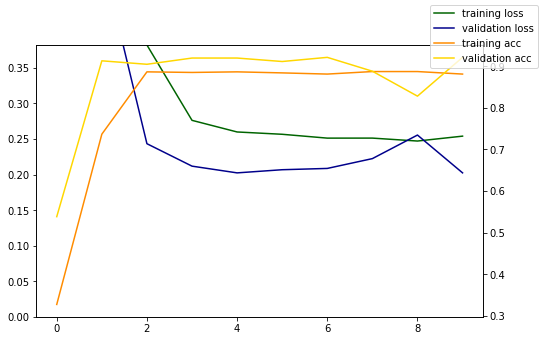

In [90]:
train_plot(model_cnn_2)

In [91]:
accr_cnn_2 = model_cnn_2.evaluate(x_preprocess_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_cnn_2[0],accr_cnn_2[1]))

19/19 [==============================] - 0s 14ms/step - loss: 0.2448 - accuracy: 0.8933
Test set
  Loss: 0.245
  Accuracy: 0.893


#### method3: using frozen layer in pre-trained network

##### network: mobile net
using frozen layer from mobile net

In [58]:
# build the base model on mobile net
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape = (100,100,3))
mobilenet.trainable = False

17235968/17225924 [==============================] - 1s 0us/step


In [96]:
model_cnn_3 = Sequential([
    # to make mobilenet accept 1 channel image, add a conv2d layer that match the input shape for mobile net
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    mobilenet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
    
model_cnn_3.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_cnn_3.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 100, 100, 3)       30        
                                                                 
 mobilenet_1.00_224 (Functio  (None, 3, 3, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_4   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_18 (Dense)            (None, 64)                65600     
                                                                 
 dense_19 (Dense)            (None, 4)                 260       
                                                                 
Total params: 3,294,754
Trainable params: 65,890
Non-

In [93]:
def train_plot(model, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(x_preprocess_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(x_preprocess_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['accuracy'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_accuracy'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

Epoch 1/20
88/88 [==============================] - 6s 40ms/step - loss: 1.3520 - accuracy: 0.3518 - val_loss: 1.2378 - val_accuracy: 0.4933
Epoch 2/20
88/88 [==============================] - 3s 32ms/step - loss: 1.1130 - accuracy: 0.5639 - val_loss: 1.0176 - val_accuracy: 0.5767
Epoch 3/20
88/88 [==============================] - 3s 32ms/step - loss: 0.9649 - accuracy: 0.6161 - val_loss: 0.8861 - val_accuracy: 0.6517
Epoch 4/20
88/88 [==============================] - 3s 32ms/step - loss: 0.8449 - accuracy: 0.6764 - val_loss: 0.7707 - val_accuracy: 0.7267
Epoch 5/20
88/88 [==============================] - 3s 32ms/step - loss: 0.7303 - accuracy: 0.7346 - val_loss: 0.6450 - val_accuracy: 0.7967
Epoch 6/20
88/88 [==============================] - 3s 32ms/step - loss: 0.6061 - accuracy: 0.8075 - val_loss: 0.5412 - val_accuracy: 0.8450
Epoch 7/20
88/88 [==============================] - 3s 32ms/step - loss: 0.5383 - accuracy: 0.8143 - val_loss: 0.5354 - val_accuracy: 0.8433
Epoch 8/20
88

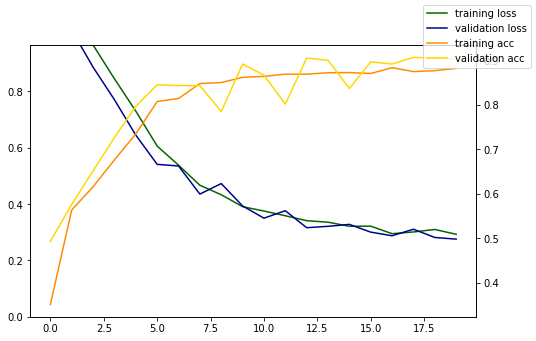

In [97]:
train_plot(model_cnn_3)

In [98]:
accr_cnn_3 = model_cnn_3.evaluate(x_preprocess_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_cnn_3[0],accr_cnn_3[1]))

19/19 [==============================] - 0s 21ms/step - loss: 0.3127 - accuracy: 0.8600
Test set
  Loss: 0.313
  Accuracy: 0.860


##### network: ResNet101V2
using frozen layers based on resnet101V2

In [100]:
from tensorflow.keras.applications import ResNet101V2

In [102]:
#build the base model layer
resnet = ResNet101V2(weights='imagenet', include_top=False, input_shape = (100,100,3))
resnet.trainable = False

In [104]:
model_cnn_4 = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    resnet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
    
model_cnn_4.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=['accuracy'])
model_cnn_4.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 100, 100, 3)       30        
                                                                 
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 global_average_pooling2d_6   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_22 (Dense)            (None, 64)                131136    
                                                                 
 dense_23 (Dense)            (None, 4)                 260       
                                                                 
Total params: 42,757,986
Trainable params: 131,426
Non-trainable params: 42,626,560
___________________________________

In [105]:
def train_plot(model, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(x_preprocess_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(x_preprocess_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['accuracy'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_accuracy'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

Epoch 1/20
88/88 [==============================] - 26s 195ms/step - loss: 1.0521 - accuracy: 0.5671 - val_loss: 0.7976 - val_accuracy: 0.7450
Epoch 2/20
88/88 [==============================] - 13s 152ms/step - loss: 0.6685 - accuracy: 0.7625 - val_loss: 0.5297 - val_accuracy: 0.8400
Epoch 3/20
88/88 [==============================] - 13s 153ms/step - loss: 0.4893 - accuracy: 0.8425 - val_loss: 0.3947 - val_accuracy: 0.8933
Epoch 4/20
88/88 [==============================] - 13s 153ms/step - loss: 0.3923 - accuracy: 0.8607 - val_loss: 0.3177 - val_accuracy: 0.9083
Epoch 5/20
88/88 [==============================] - 14s 154ms/step - loss: 0.3344 - accuracy: 0.8739 - val_loss: 0.2855 - val_accuracy: 0.9200
Epoch 6/20
88/88 [==============================] - 14s 154ms/step - loss: 0.3053 - accuracy: 0.8832 - val_loss: 0.2733 - val_accuracy: 0.9100
Epoch 7/20
88/88 [==============================] - 13s 152ms/step - loss: 0.2869 - accuracy: 0.8825 - val_loss: 0.2874 - val_accuracy: 0.9167

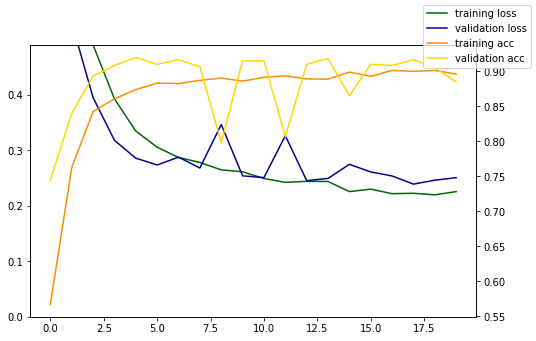

In [106]:
train_plot(model_cnn_4)

In [107]:
accr_cnn_4 = model_cnn_4.evaluate(x_preprocess_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_cnn_4[0],accr_cnn_4[1]))

19/19 [==============================] - 2s 64ms/step - loss: 0.2707 - accuracy: 0.8683
Test set
  Loss: 0.271
  Accuracy: 0.868


##### method4: adjust pretrained model
Unfreeze some layers from 300 to 377, to adjust the resnet model

In [108]:
# set the model to trainable
resnet.trainable = True

In [110]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  377


In [111]:
model_cnn_5 = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    resnet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
### set lower learning rate to avoid overfitting
model_cnn_5.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model_cnn_5.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_41 (Conv2D)          (None, 100, 100, 3)       30        
                                                                 
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 global_average_pooling2d_7   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_24 (Dense)            (None, 64)                131136    
                                                                 
 dense_25 (Dense)            (None, 4)                 260       
                                                                 
Total params: 42,757,986
Trainable params: 19,310,434
Non-trainable params: 23,447,552
________________________________

In [112]:
def train_plot(model, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights=True)
    log = model.fit(x_preprocess_train, y_train, epochs=epochs,batch_size=32,
                        validation_data=(x_preprocess_valid, y_valid),
                   callbacks = [early_stopping_cb])
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax.plot(log.history['val_loss'], label = "validation loss",color='darkblue')
    ax2=ax.twinx()
    ax2.plot(log.history['accuracy'],label = "training acc",color='darkorange')
    ax2.plot(log.history['val_accuracy'], label = "validation acc",color='gold')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

Epoch 1/20
88/88 [==============================] - 26s 193ms/step - loss: 0.3772 - accuracy: 0.8443 - val_loss: 1.5516 - val_accuracy: 0.2600
Epoch 2/20
88/88 [==============================] - 15s 168ms/step - loss: 0.2833 - accuracy: 0.8789 - val_loss: 0.3768 - val_accuracy: 0.8883
Epoch 3/20
88/88 [==============================] - 15s 169ms/step - loss: 0.2847 - accuracy: 0.8779 - val_loss: 0.2171 - val_accuracy: 0.9150
Epoch 4/20
88/88 [==============================] - 15s 167ms/step - loss: 0.2466 - accuracy: 0.8921 - val_loss: 0.2300 - val_accuracy: 0.9200
Epoch 5/20
88/88 [==============================] - 15s 167ms/step - loss: 0.2644 - accuracy: 0.8889 - val_loss: 0.2198 - val_accuracy: 0.9217
Epoch 6/20
88/88 [==============================] - 15s 171ms/step - loss: 0.2313 - accuracy: 0.8925 - val_loss: 0.2128 - val_accuracy: 0.9217
Epoch 7/20
88/88 [==============================] - 15s 171ms/step - loss: 0.2245 - accuracy: 0.9007 - val_loss: 0.2031 - val_accuracy: 0.9200

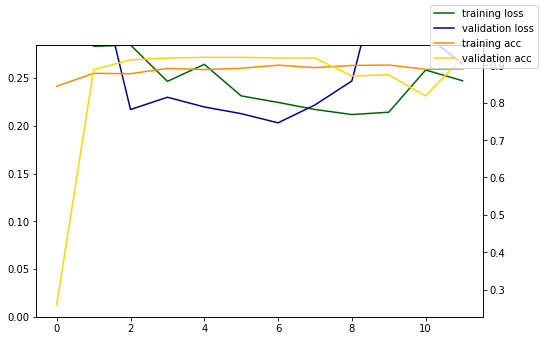

In [113]:
train_plot(model_cnn_5)

In [114]:
accr_cnn_5 = model_cnn_5.evaluate(x_preprocess_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_cnn_5[0],accr_cnn_5[1]))

19/19 [==============================] - 1s 63ms/step - loss: 0.2308 - accuracy: 0.8933
Test set
  Loss: 0.231
  Accuracy: 0.893


In [196]:
df_accr_cnn = {'CNN_1': accr_cnn, 'CNN_2(add layer)': accr_cnn_1, 'CNN_3_scale_data': accr_cnn_2,
'CNN_4_mobilenet':accr_cnn_3,'CNN_5_resnet':accr_cnn_4,'CNN_6_adjusted_resnet':accr_cnn_5}
df_accr_cnn = pd.DataFrame(df_accr_cnn,index=['Loss','Accuracy'])
df_accr_cnn

,CNN_1,CNN_2(add layer),CNN_3_scale_data,CNN_4_mobilenet,CNN_5_resnet,CNN_6_adjusted_resnet
Loss,0.287347,0.253457,0.244777,0.312713,0.270653,0.230762
Accuracy,0.878333,0.851667,0.893333,0.860000,0.868333,0.893333


### Task 6
Compare the models you have created so far (both RNNs and CNNs) and make a
selection (making sure to justify this). Train that model on a combined training and
validation set and evaluate it on your test set.

In [158]:
# split the data
X_train, X_other, y_train, y_other = train_test_split(data, y_cate, test_size=0.3, random_state = 657)
X_test, X_valid, y_test, y_valid = train_test_split(X_other, y_other, train_size = 0.5, random_state=391)

In [159]:
# combine the train and valid dataset into a new train dataset
new_train_x = np.concatenate((X_train, X_valid), axis=0)
new_train_y = np.concatenate((y_train,y_valid),axis=0)

In [160]:
new_train_x.shape, new_train_y.shape

((3400, 5000, 2), (3400, 4))

### conv1d

In [132]:
def train_plot(model, learning_rate = 0.001, epochs = 40):
    np.random.seed(312)
    tf.random.set_seed(312)

    model.compile(loss="categorical_crossentropy",metrics = "acc",
                  optimizer=Adam(learning_rate = learning_rate))
    log = model.fit(new_train_x, new_train_y, epochs=epochs,batch_size=32)
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax2=ax.twinx()
    ax2.plot(log.history['acc'],label = "training acc",color='darkorange')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

In [133]:
# Conv 1D
model_conv1d = Sequential([
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",input_shape=[None, 2]),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    Conv1D(filters=20, kernel_size=4, strides=2, padding="valid"),
    GRU(128),
    Dense(4, activation="softmax")
])
model_conv1d.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 20)          180       
                                                                 
 conv1d_4 (Conv1D)           (None, None, 20)          1620      
                                                                 
 conv1d_5 (Conv1D)           (None, None, 20)          1620      
                                                                 
 gru_1 (GRU)                 (None, 128)               57600     
                                                                 
 dense_28 (Dense)            (None, 4)                 516       
                                                                 
Total params: 61,536
Trainable params: 61,536
Non-trainable params: 0
_________________________________________________________________


Epoch 1/40
107/107 [==============================] - 5s 29ms/step - loss: 1.0766 - acc: 0.5365
Epoch 2/40
107/107 [==============================] - 3s 28ms/step - loss: 0.6627 - acc: 0.7521
Epoch 3/40
107/107 [==============================] - 3s 28ms/step - loss: 0.4036 - acc: 0.8515
Epoch 4/40
107/107 [==============================] - 3s 28ms/step - loss: 0.3231 - acc: 0.8765
Epoch 5/40
107/107 [==============================] - 3s 28ms/step - loss: 0.2906 - acc: 0.8844
Epoch 6/40
107/107 [==============================] - 3s 28ms/step - loss: 0.2630 - acc: 0.8862
Epoch 7/40
107/107 [==============================] - 3s 28ms/step - loss: 0.2416 - acc: 0.8956
Epoch 8/40
107/107 [==============================] - 3s 28ms/step - loss: 0.2264 - acc: 0.9003
Epoch 9/40
107/107 [==============================] - 3s 28ms/step - loss: 0.2156 - acc: 0.9074
Epoch 10/40
107/107 [==============================] - 3s 28ms/step - loss: 0.2208 - acc: 0.9006
Epoch 11/40
107/107 [==================

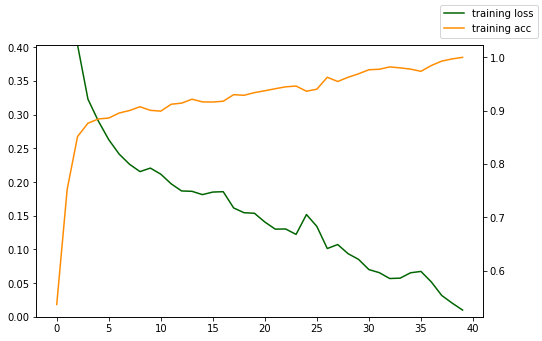

In [134]:
train_plot(model_conv1d)

In [135]:
accr_conv1d = model_conv1d.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_conv1d[0],accr_conv1d[1]))

19/19 [==============================] - 1s 28ms/step - loss: 0.5215 - acc: 0.8517
Test set
  Loss: 0.521
  Accuracy: 0.852


### prescaled data + adjusted resnet

In [161]:
num_classes = 4 # number of classes in the data
img_rows, img_cols, img_channels = 100, 100, 1 # input image dimensions

# Load and convert data
new_train_x = new_train_x.astype('float32')
X_test = X_test.astype('float32')

# Depending on the implementation, the underlying libraries might want the image 
# dimensions in different orders, check for it and reshape
if K.image_data_format() == 'channels_first':
    new_train_x = new_train_x.reshape(new_train_x.shape[0], img_channels, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], img_channels, img_rows, img_cols)
    input_shape = (img_channels, img_rows, img_cols)
else:
    new_train_x = new_train_x.reshape(new_train_x.shape[0], img_rows, img_cols, img_channels)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, img_channels)
    input_shape = (img_rows, img_cols, img_channels)

print('x_train shape:', new_train_x.shape)
print('y_train shape:', y_train.shape)

x_train shape: (3400, 100, 100, 1)
y_train shape: (2800, 4)


In [162]:
x_preprocess_train = preprocess_input(new_train_x.copy())
x_preprocess_test = preprocess_input(X_test.copy())
x_preprocess_train.shape, x_preprocess_test.shape

((3400, 100, 100, 1), (600, 100, 100, 1))

In [163]:
resnet = ResNet101V2(weights='imagenet', include_top=False, input_shape = (100,100,3))
resnet.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(resnet.layers))

# Fine-tune from this layer onwards
fine_tune_at = 300

# Freeze all the layers before the `fine_tune_at` layer
for layer in resnet.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  377


In [164]:
model_res = Sequential([
    Conv2D(3, kernel_size=(3, 3),strides=(1,1),padding='same',input_shape=input_shape),
    resnet,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')])
### set lower learning rate to avoid overfitting
model_res.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])
model_res.summary()

Model: "sequential_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 100, 100, 3)       30        
                                                                 
 resnet101v2 (Functional)    (None, 4, 4, 2048)        42626560  
                                                                 
 global_average_pooling2d_10  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_33 (Dense)            (None, 64)                131136    
                                                                 
 dense_34 (Dense)            (None, 4)                 260       
                                                                 
Total params: 42,757,986
Trainable params: 19,310,434
Non-trainable params: 23,447,552
________________________________

In [165]:
def train_plot(model, epochs = 20):
    np.random.seed(312)
    tf.random.set_seed(312)

    log = model.fit(x_preprocess_train, new_train_y, epochs=epochs,batch_size=32)
    fig,ax = plt.subplots(figsize=(8,5))
    ax.plot(log.history['loss'],label = "training loss",color='darkgreen')
    ax2=ax.twinx()
    ax2.plot(log.history['accuracy'],label = "training acc",color='darkorange')
    fig.legend()
    #ax = plt.gca()
    ax.set_ylim([0, log.history['loss'][2]])
    plt.show()
    
    return model

Epoch 1/20
107/107 [==============================] - 26s 161ms/step - loss: 0.3498 - accuracy: 0.8638
Epoch 2/20
107/107 [==============================] - 16s 153ms/step - loss: 0.2711 - accuracy: 0.8882
Epoch 3/20
107/107 [==============================] - 16s 154ms/step - loss: 0.2603 - accuracy: 0.8921
Epoch 4/20
107/107 [==============================] - 17s 154ms/step - loss: 0.2349 - accuracy: 0.9003
Epoch 5/20
107/107 [==============================] - 17s 155ms/step - loss: 0.2602 - accuracy: 0.8929
Epoch 6/20
107/107 [==============================] - 17s 156ms/step - loss: 0.2325 - accuracy: 0.9006
Epoch 7/20
107/107 [==============================] - 17s 156ms/step - loss: 0.2444 - accuracy: 0.8944
Epoch 8/20
107/107 [==============================] - 17s 157ms/step - loss: 0.2530 - accuracy: 0.8976
Epoch 9/20
107/107 [==============================] - 17s 158ms/step - loss: 0.2231 - accuracy: 0.9003
Epoch 10/20
107/107 [==============================] - 17s 159ms/step - l

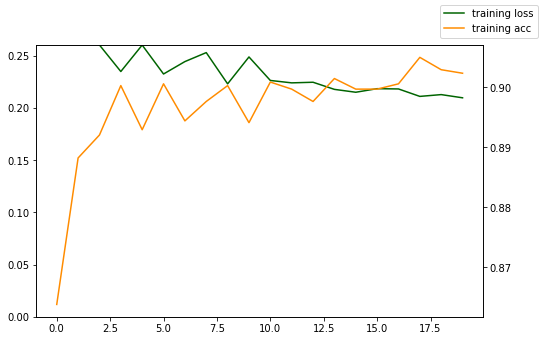

In [166]:
train_plot(model_res)

In [167]:
accr_resfin = model_res.evaluate(x_preprocess_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr_resfin[0],accr_resfin[1]))

19/19 [==============================] - 3s 63ms/step - loss: 0.2307 - accuracy: 0.8817
Test set
  Loss: 0.231
  Accuracy: 0.882


In [197]:
df_accr_fin = {'conv1d': accr_conv1d, 'resnet': accr_resfin}
df_accr_fin = pd.DataFrame(df_accr_fin,index=['Loss','Accuracy'])
df_accr_fin

,conv1d,resnet
Loss,0.521486,0.230716
Accuracy,0.851667,0.881667


Consider both the loss and the accuracy, resnet model will be chosed as the final model.

In [168]:
model_res.save("best_model_res.h5")